# Description

* Simulating CsCl gradient to reproduce the results in:
> Lueders T, Manefield M, Friedrich MW. (2004). Enhanced sensitivity of DNA- and rRNA-based stable isotope probing by fractionation and quantitative analysis of isopycnic centrifugation gradients. Environmental Microbiology 6:73–78.

* rotor:
  * TV865
* rotor speed:
  * 45000 rpm
* spin time:
  * \>36 hr
* gradient average density:
  * 1.725 g/ml
* Fraction sizes:
  * 400 ul
* Used gDNA
  * 13C-labeled
  * 13C-methanol
  * 5 ug
* strains
  * Methylobacterium extorquens AM1 DSM 1338
  * M. barkeri DSM 800
  

# Setting variables

In [30]:
workDir = "/home/nick/notebook/SIPSim/t/M.bark_M.ext/"

# Init

In [1]:
import os
import sys
%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Downloading genomes

* M. barkeri DSM 800
  * RefSeq = NC_007355.1, NC_007349.1
* Methylobacterium extorquens AM1 DSM 1338
  * RefSeq = NC_012808.1, NC_012811.1, NC_012807.1, NC_012809.1, NC_012810.1

In [4]:
!cd $workDir; \
    seqDB_tools accession-GI2fasta < M.barkeri_refseq.txt > M.barkeri.fna

Starting batch: 1
Starting trial: 1

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_007355|Methanosarcina barkeri str. Fusaro, complete genome.]
---------------------------------------------------

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_007355|Methanosarcina barkeri str. Fusaro, complete genome.]
---------------------------------------------------

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_007349|Methanosarcina barkeri str. fusaro plasmid 1, complete sequence.]
---------------------------------------------------

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_007349|Methanosarcina barkeri str. fusaro plasmid 1, complete sequence.]
---------------------------------------------------


In [5]:
!cd $workDir; \
    seqDB_tools accession-GI2fasta < M.extorquens_AM1_refseq.txt > M.extorquens_AM1.fna

Starting batch: 1
Starting trial: 1

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_012808|Methylobacterium extorquens AM1, complete genome.]
---------------------------------------------------

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_012808|Methylobacterium extorquens AM1, complete genome.]
---------------------------------------------------

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_012811|Methylobacterium extorquens AM1 megaplasmid, complete sequence.]
---------------------------------------------------

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_012811|Methylobacterium extorquens AM1 megaplasmid, complete sequence.]
---------------------------------------------------

--------------------- WARNING ---------------------
MSG: No whitespace allowed in FASTA ID [NC_012807|Methyloba

# Indexing genomes

In [12]:
# renaming genome sequences
!cd $workDir; \
    find . -name "*_rn.fna" |\
    xargs -I % rm -f %
    
!cd $workDir; \
    find . -name "*.fna" |\
    perl -pe 's/\.fna$//' | \
    xargs -P 2 -I % bash -c \
    "SIPSim renameGenomes %.fna > %_rn.fna"

In [13]:
# list of all genomes files and their associated names
!cd $workDir; \
    find . -name "*_rn.fna" | \
    perl -pe 's/.+\///' | \
    perl -pe 's/(.+)(\.[^.]+)/\$1\t\$1\$2/' > genomes_all_list.txt
    
!cd $workDir; head genomes_all_list.txt

M.extorquens_AM1_rn	M.extorquens_AM1_rn.fna
M.barkeri_rn	M.barkeri_rn.fna


In [15]:
!cd $workDir; \
    SIPSim indexGenomes genomes_all_list.txt \
    --np 2 > index_log.txt

Indexing: "M.extorquens_AM1_rn"
Indexing: "M.barkeri_rn"


# Simulating a gradient community

In [26]:
!cd $workDir; \
    SIPSim gradientComms \
    --n_comm 1 \
    --abund_dist uniform \
    --abund_dist_p low:1,high:1 \
    genomes_all_list.txt > comm-n1-unif.txt
    
!cd $workDir; tail comm-n1-unif.txt

library	taxon_name	rel_abund_perc	rank
1	M.extorquens_AM1_rn	50.000000000	1
1	M.barkeri_rn	50.000000000	2


# Simulating isotope incorporation

In [27]:
# making config file
config = """
[library 1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [28]:
!cd $workDir; \
    SIPSim isoIncorp \
    comm-n1-unif.txt incorp.config \
    > incorp-n1-unif.txt
    
!cd $workDir; head incorp-n1-unif.txt

library	taxon_name	distribution_index	distribution	weight	param	param_value
1	M.barkeri_rn	1	uniform	1.0	start	0.0
1	M.barkeri_rn	1	uniform	1.0	end	0.0
1	M.extorquens_AM1_rn	1	uniform	1.0	start	0.0
1	M.extorquens_AM1_rn	1	uniform	1.0	end	0.0


In [87]:
%%bash -s "$workDir"
# adding incorp 100% library for N.extorquens
cd $1

cat incorp-n1-unif.txt \
    <(tail -n +2 incorp-n1-unif.txt | \
    perl -pe 's/^1/2/' | \
    perl -pe 's/0\.0/100.0/ if /M.extorquens/') \
    > incorp-n2-unif.txt
    
    
head incorp-n2-unif.txt

library	taxon_name	distribution_index	distribution	weight	param	param_value
1	M.barkeri_rn	1	uniform	1.0	start	0.0
1	M.barkeri_rn	1	uniform	1.0	end	0.0
1	M.extorquens_AM1_rn	1	uniform	1.0	start	0.0
1	M.extorquens_AM1_rn	1	uniform	1.0	end	0.0
2	M.barkeri_rn	1	uniform	1.0	start	0.0
2	M.barkeri_rn	1	uniform	1.0	end	0.0
2	M.extorquens_AM1_rn	1	uniform	1.0	start	100.0
2	M.extorquens_AM1_rn	1	uniform	1.0	end	100.0


# Resimulating community (n=2)

In [90]:
!cd $workDir; \
    SIPSim gradientComms \
    --n_comm 2 \
    --abund_dist uniform \
    --abund_dist_p low:1,high:1 \
    genomes_all_list.txt > comm-n2-unif.txt
    
!cd $workDir; tail comm-n2-unif.txt

library	taxon_name	rel_abund_perc	rank
1	M.extorquens_AM1_rn	50.000000000	1
1	M.barkeri_rn	50.000000000	2
2	M.extorquens_AM1_rn	50.000000000	1
2	M.barkeri_rn	50.000000000	2


# Simulating gradient fractions

In [97]:
!cd $workDir; \
    SIPSim fractions \
    comm-n2-unif.txt \
    > fracs-n2-unif.txt
    
!cd $workDir; head fracs-n2-unif.txt

library	fraction	BD_min	BD_max	fraction_size
1	1	1.66	1.666	0.006
1	2	1.666	1.67	0.004
1	3	1.67	1.671	0.001
1	4	1.671	1.676	0.005
1	5	1.676	1.678	0.002
1	6	1.678	1.681	0.003
1	7	1.681	1.686	0.005
1	8	1.686	1.69	0.004
1	9	1.69	1.694	0.004


# Simulating shotgun fragments & calculating GC

In [38]:
!cd $workDir;\
    SIPSim fragGC \
    genomes_all_list.txt \
    --flr 500,None \
    --fld skewed-normal,9000,2500,-5 \
    --nf 50x \
    --np 24 \
    2> shotFragGC_skewN90-25-n5-nS.log \
    > shotFragGC_skewN90-25-n5-nS.pkl
    
!cd $workDir; head shotFragGC_skewN90-25-n5-nS.log

Processing: "M.extorquens_AM1_rn"
Processing: "M.barkeri_rn"
  Genome name: M.barkeri_rn
  Genome length (bp): 4873766
  Number of amplicons: None
  Number of fragments simulated: 34679
  Genome name: M.extorquens_AM1_rn
  Genome length (bp): 6879778
  Number of amplicons: None
  Number of fragments simulated: 48864


# Creating OTU table

In [116]:
!cd $workDir; \
    SIPSim OTU_sim \
    shotFragGC_skewN90-25-n5-nS.pkl \
    comm-n2-unif.txt \
    incorp-n2-unif.txt \
    fracs-n2-unif.txt \
    --abs_abund 2e6 \
    2> OTU-n2-unif_skewN90-25-n5-nS_A2e9.log \
    > OTU-n2-unif_skewN90-25-n5-nS_A2e9.txt
    
!cd $workDir; head OTU-n2-unif_skewN90-25-n5-nS_A2e9.log 

Loading files...
Creating 2d-KDEs of fragment GC & length...
Creating OTUs...
Processing library: "1"
  Processing taxon: "M.extorquens_AM1_rn"
    N-fragments:   1000000
     Elapsed:     0.2 sec => GC/fragment_length KDE sampled
     Elapsed:     2.2 sec => diffusion added to BD values
     Elapsed:     6.5 sec => isotope incorporation added to BD values
     Elapsed:     7.0 sec => binned BD values


# Plotting OTU abundances

In [117]:
%%R -i workDir

# loading file
inFiles = c('OTU-n2-unif_skewN90-25-n5-nS_A2e9.txt')

inFiles = sapply(inFiles, function(x){
            x = as.character(x)
            paste(c(workDir, x), collapse='/')
    })


tbls = list()
for (fileName in inFiles){
    tbls[[fileName]] = read.csv(fileName, sep='\t')
    }
tbl = do.call(rbind, tbls)
tbl$abs_abund = as.numeric(gsub('.+-nS_A|\\.txt\\.[0-9]+', '', rownames(tbl)))

tbl = tbl %>% 
    filter(!grepl('inf', fractions, ignore.case=T)) %>%
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

In [118]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

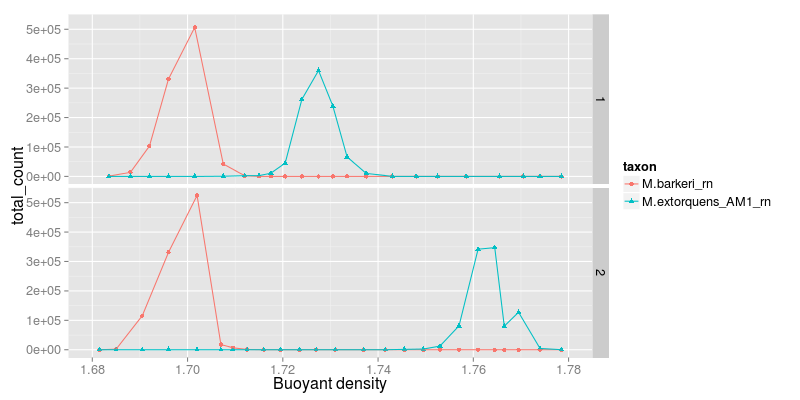

In [119]:
%%R -w 800 -h 400
# plotting absolute abundances

tbl.s = tbl %>%
    mutate(BD_mean = (BD_min + BD_max) / 2) %>%
    group_by(abs_abund, BD_mean, library, taxon) %>%
    summarize(total_count = sum(count))


## plot
p = ggplot(tbl.s, aes(BD_mean, total_count, shape=taxon, color=taxon)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(limits=c(1.68,1.78), breaks=seq(1.68,1.78,0.02)) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme( 
        text = element_text(size=16) 
    )
p